In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA

In [49]:
sns.set(style="darkgrid", font="Arial", font_scale=1.5)

In [50]:
# read in data
raw = pd.read_csv("PCA-KC Data-Assignment.csv").drop("Unnamed: 0", axis=1)
raw

,NBH_ID,NBH_NAME,total crime,violent crime,property crime,Median income,Median home value,Population with BS or More,White alone,Black or African American alone,...,Number of Households,Walk Score,Transit Score,Bike Score,Population,Animals / Pets,City Facilities,Lights / Signals,Mowing / Weeds,Trash / Recycling
0,177,Country Valley-Hawthorn Square,456,848,358,56044,156425,434,1513,298,...,938,15,15.0,25,1414,1.000000,NaN,7.000000,NaN,12.040000
1,29,East Community Team North,431,980,332,27803,62380,34,143,358,...,328,47,35.0,33,3352,13.419753,NaN,3.083333,125.000000,33.345070
2,221,The Coves,392,91,687,71767,266200,595,1339,111,...,701,31,26.0,28,3997,12.571429,NaN,2.454545,2.000000,5.770115
3,119,Blue Hills,390,1105,262,37498,58311,91,90,717,...,365,50,43.0,36,5359,17.921348,NaN,2.428571,98.133333,38.679842
4,50,Vineyard Estates,385,304,401,39375,28200,86,39,652,...,349,6,31.0,30,739,1.240000,NaN,2.000000,NaN,16.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,239,Ridgefield,89,31,60,82241,183371,421,1143,85,...,506,12,18.0,29,4975,1.833333,NaN,2.739130,65.000000,18.304348
195,39,Riss Lake,70,65,240,49849,99100,147,582,525,...,570,19,36.0,19,2631,9.347826,NaN,5.500000,56.000000,52.408163
196,190,River View,54,76,127,56404,139900,209,615,62,...,419,33,27.0,23,1550,2.272727,NaN,14.000000,41.500000,20.893617
197,8,Westside North,122,277,83,50958,210200,379,525,148,...,542,68,54.0,49,1930,5.000000,NaN,11.590909,NaN,14.084507


In [51]:
raw.columns

Index(['NBH_ID', 'NBH_NAME', 'total crime', 'violent crime', 'property crime',
       'Median income', 'Median home value', 'Population with BS or More',
       'White alone', 'Black or African American alone', 'Asian alone',
       'Hispanic or Latino', 'Total Vacant', 'Total Renter Occupied',
       'Number of Households', 'Walk Score', 'Transit Score', 'Bike Score',
       'Population', 'Animals / Pets', 'City Facilities', 'Lights / Signals',
       'Mowing / Weeds', 'Trash / Recycling'],
      dtype='object')

In [52]:
raw.shape

(199, 24)

In [53]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   NBH_ID                           199 non-null    int64  
 1   NBH_NAME                         199 non-null    object 
 2   total crime                      199 non-null    int64  
 3   violent crime                    199 non-null    int64  
 4   property crime                   199 non-null    int64  
 5   Median income                    199 non-null    int64  
 6   Median home value                199 non-null    int64  
 7   Population with BS or More       199 non-null    int64  
 8   White alone                      199 non-null    int64  
 9   Black or African American alone  199 non-null    int64  
 10  Asian alone                      199 non-null    int64  
 11  Hispanic or Latino               199 non-null    int64  
 12  Total Vacant          

City Facilities is ~96% sparse and will have to be dropped.

In [54]:
Corr = raw.corr()
px.imshow(Corr, width=720, height=720)

In [55]:
# Graph the correlation matrix, highlighting coordinate pairs with high Pearson correlation coefficients
highCorr = raw.corr() [abs(raw.corr()) > 0.7]
px.imshow(highCorr, width=720, height=720)

**Highly Correlated Variables**

In [56]:
corr = raw.corr()
print("Total Crime vs. Violet Crime: {:.3f}".format(float(corr["total crime"]["violent crime"])))
print("Total Crime vs. Property Crime: {:.3f}".format(float(corr["total crime"]["property crime"])))
print("Medium Income vs. Medium Home Value: {:.3f}".format(float(corr["Median income"]["Median home value"])))
print("White Alone vs. Population with BS or More: {:.3f}".format(float(corr["White alone"]["Population with BS or More"])))
print("Walk Score vs. Transit Score: {:.3f}".format(float(corr["Walk Score"]["Transit Score"])))
print("Walk Score vs. Bike Score: {:.3f}".format(float(corr["Walk Score"]["Bike Score"])))
print("Bike Score vs. Transit Score: {:.3f}".format(float(corr["Transit Score"]["Bike Score"])))

Total Crime vs. Violet Crime: 0.742
Total Crime vs. Property Crime: 0.811
Medium Income vs. Medium Home Value: 0.825
White Alone vs. Population with BS or More: 0.836
Walk Score vs. Transit Score: 0.803
Walk Score vs. Bike Score: 0.852
Bike Score vs. Transit Score: 0.726


Regarding the above, our two most highly-correlated variable pairs are:
* Bike Score and Walk Score
* White Alone vs. Population with BS or More

Since Bike Score is less correlated with Transit Score than its closely related Walk Score, let's consider dropping this one.
Regaridng the variables White Alone and Population with BS or More, the progression is less clear. However, since White Alone is not the only race-dependent category, dropping the column Population with BS or More may be more suitable.

In the following, we'll use estiamted cumulative explained variance for normalized versions of the data with and without drops to score a relativly optimized dimensional reduction of the given data. Let

* ${X_0}$ be the null dataset
* ${X_A}$ be ${X_0}$ with Bike Score, Population, and Population with BS or More dropped from consideration

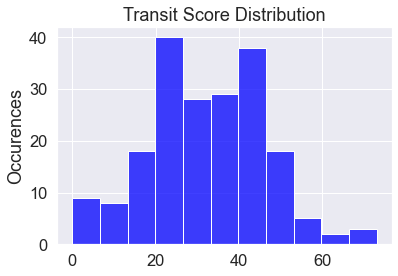

In [57]:
sns.histplot(data=raw["Transit Score"], color="blue")
plt.xlabel("")
plt.ylabel("Occurences")
plt.title("Transit Score Distribution")
plt.show()

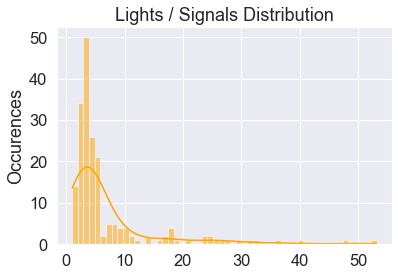

In [58]:
sns.histplot(data=raw["Lights / Signals"], color="Orange", kde=True)
plt.xlabel("")
plt.ylabel("Occurences")
plt.title("Lights / Signals Distribution")
plt.show()

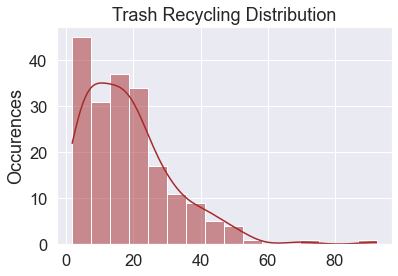

In [59]:
sns.histplot(data=raw["Trash / Recycling"], color="Brown", kde=True)
plt.xlabel("")
plt.ylabel("Occurences")
plt.title("Trash Recycling Distribution")
plt.show()

The above varaibles are not heavily grouped about thier mean, so imputation may not be the best path, or even valid in the case of Mowing / Weeds.

In [60]:
X0 = raw.loc[:, "total crime": "Trash / Recycling"].drop("City Facilities", axis=1).dropna().values
XA = raw.loc[:, "total crime": "Trash / Recycling"].drop(
    ["Bike Score", "Population with BS or More", "Population", "City Facilities", "Mowing / Weeds"], axis=1).dropna().values


In [61]:
# Noramlize the data
normalizerA =  MinMaxScaler().fit(X0)
normalizerB = MinMaxScaler().fit(XA)
X0_norm = normalizerA.transform(X0)
XA_norm = normalizerB.transform(XA)
# Fit PCA sets
pcaGenNull = PCA().fit(X0_norm)
pcaGenAlt = PCA().fit(XA_norm)

In [62]:
Y = pd.DataFrame()
Y["Null ExpVar"] = np.cumsum(pcaGenNull.explained_variance_ratio_)

temp = np.ones(21,)
for i in range(17):
    temp[i] =  np.cumsum(pcaGenAlt.explained_variance_ratio_)[i]
Y["Alt ExpVar"] = temp
Y['newIndex'] = range(1, 22)
Y.set_index("newIndex")

,Null ExpVar,Alt ExpVar
newIndex,,
1,0.316516,0.289660
2,0.474390,0.479012
3,0.566887,0.597791
4,0.651570,0.686315
5,0.718282,0.744671
6,0.764550,0.790601
7,0.805592,0.828728
8,0.838633,0.864626
9,0.869260,0.896865


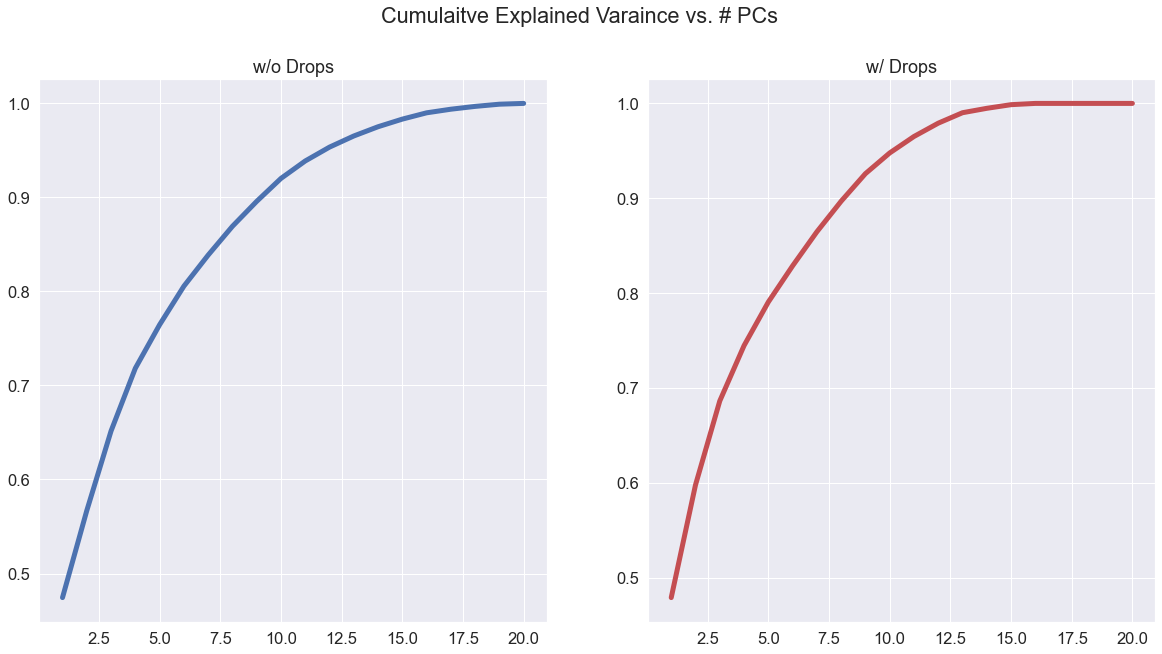

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Cumulaitve Explained Varaince vs. # PCs")

ax1.set_title("w/o Drops")
ax2.set_title("w/ Drops")

ax1.plot(Y["Null ExpVar"][1:], lw=5.0)
ax2.plot(Y["Alt ExpVar"][1:], lw=5.0, color='r')
plt.savefig("graphics/CEV vs PC")

Based on the above, dropping the columns "Bike Score", "Population", and "Population with BS or More" make **VERY MININIMAL DIFFERENCE** in the dimension reduction's explained varaince. 

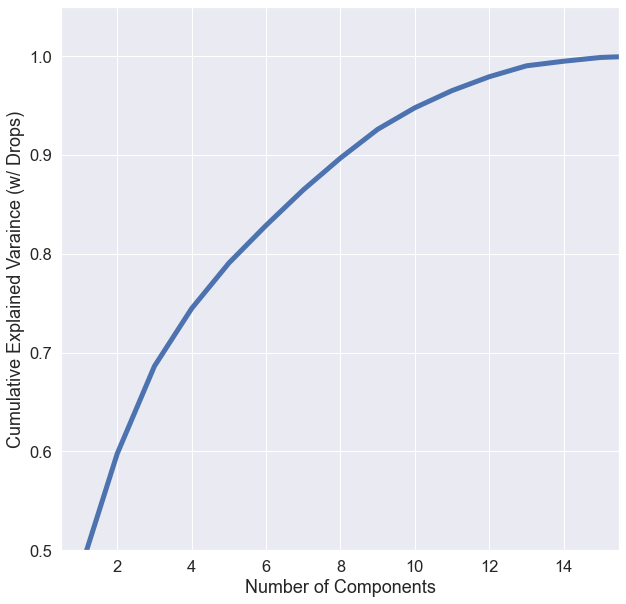

In [64]:
plt.figure(figsize=(10, 10))
plt.plot(Y["Alt ExpVar"][1:], lw=5.0)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Varaince (w/ Drops)")
plt.xlim(0.5, 15.5)
plt.ylim(0.5, 1.05)
plt.savefig("graphics\pcaExpVar1.png")

In [74]:
X = raw.loc[:, "total crime": "Trash / Recycling"].drop(
    ["Population", "City Facilities", "Mowing / Weeds"], axis=1).dropna()

X.to_csv("data\PCA X Data1.csv")

In [75]:
X.drop(["Animals / Pets", "Lights / Signals"], axis=1).to_csv("data\PCA X Data2.csv")

In [69]:
X.columns

Index(['total crime', 'violent crime', 'property crime', 'Median income',
       'Median home value', 'Population with BS or More', 'White alone',
       'Black or African American alone', 'Asian alone', 'Hispanic or Latino',
       'Total Vacant', 'Total Renter Occupied', 'Number of Households',
       'Walk Score', 'Transit Score', 'Animals / Pets', 'Lights / Signals',
       'Trash / Recycling'],
      dtype='object')